In [4]:
import sklearn

In [5]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [6]:
print(f"First 5 samples of X:\n {X[:5]}\n")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y:
 [1 1 1 1 0]


In [7]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


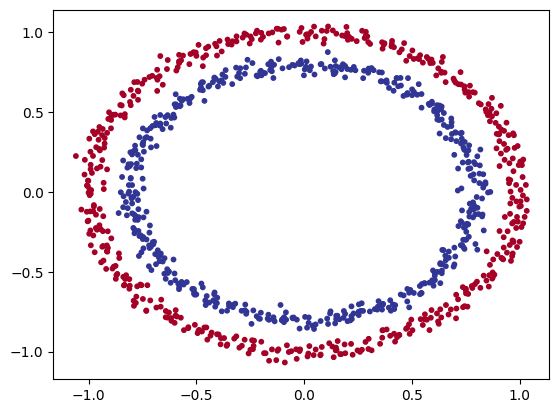

In [8]:
import matplotlib.pyplot as plt
plt.scatter(circles['X1'],
            circles['X2'],
            c=circles['label'],
            cmap=plt.cm.RdYlBu,
            s=10);

In [9]:
X_sample = X[0]
y_sample = y[0]

X_sample, y_sample, X_sample.shape, y_sample.shape

(array([0.75424625, 0.23148074]), 1, (2,), ())

In [10]:
import torch
from torch import nn

In [11]:
# turning data into tensors

X = torch.from_numpy(X).type(torch.float)

X[:5], X.shape

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 torch.Size([1000, 2]))

In [12]:
y = torch.from_numpy(y).type(torch.float)#.unsqueeze(dim=1)
y[:5]

tensor([1., 1., 1., 1., 0.])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [15]:
class CircleModule(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x: torch.tensor):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModule().to(device)

model_0

CircleModule(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4653, -0.4379],
                      [ 0.4952,  0.0113],
                      [-0.0728, -0.2887],
                      [-0.2730, -0.1418],
                      [ 0.5946,  0.5911]])),
             ('0.bias', tensor([0.1345, 0.3249, 0.5697, 0.1635, 0.5948])),
             ('1.weight',
              tensor([[-0.0140,  0.1226,  0.3028, -0.1090, -0.3923]])),
             ('1.bias', tensor([-0.3296]))])

In [19]:
with torch.inference_mode():
  untrained_preds = model_0.forward(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])


In [20]:
# loss fn and optimizer

loss_fn = nn.BCEWithLogitsLoss() # sigmoid not required

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [22]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5132],
        [-0.6572],
        [-0.1657],
        [-0.6115],
        [-0.2136]])

In [23]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3745],
        [0.3414],
        [0.4587],
        [0.3517],
        [0.4468]])

In [24]:
y_preds = torch.round(y_pred_probs)

y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))
y_preds.squeeze() == y_preds_labels.squeeze()

tensor([True, True, True, True, True])

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  #forward pass
  y_logits = model_0.forward(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  #loss
  train_loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  #zero grad
  optimizer.zero_grad()

  #backprop
  train_loss.backward()

  #step
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}\nTrain loss: {train_loss:.5f}\tTrain Acc: {acc:.2f}%\nTest loss: {test_loss:.5f} \tTest Acc: {test_acc:.2f}%\n")

Epoch: 0
Train loss: 0.71714	Train Acc: 50.00%
Test loss: 0.70805 	Test Acc: 50.00%

Epoch: 10
Train loss: 0.70383	Train Acc: 41.12%
Test loss: 0.69663 	Test Acc: 43.50%

Epoch: 20
Train loss: 0.69877	Train Acc: 46.62%
Test loss: 0.69278 	Test Acc: 49.50%

Epoch: 30
Train loss: 0.69667	Train Acc: 47.62%
Test loss: 0.69161 	Test Acc: 52.00%

Epoch: 40
Train loss: 0.69567	Train Acc: 48.00%
Test loss: 0.69137 	Test Acc: 51.50%

Epoch: 50
Train loss: 0.69512	Train Acc: 48.88%
Test loss: 0.69146 	Test Acc: 52.50%

Epoch: 60
Train loss: 0.69476	Train Acc: 49.00%
Test loss: 0.69165 	Test Acc: 52.50%

Epoch: 70
Train loss: 0.69451	Train Acc: 49.38%
Test loss: 0.69187 	Test Acc: 52.50%

Epoch: 80
Train loss: 0.69432	Train Acc: 49.38%
Test loss: 0.69209 	Test Acc: 51.00%

Epoch: 90
Train loss: 0.69417	Train Acc: 49.75%
Test loss: 0.69230 	Test Acc: 49.00%



In [26]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  print("Downloaded helpers_functions")

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists


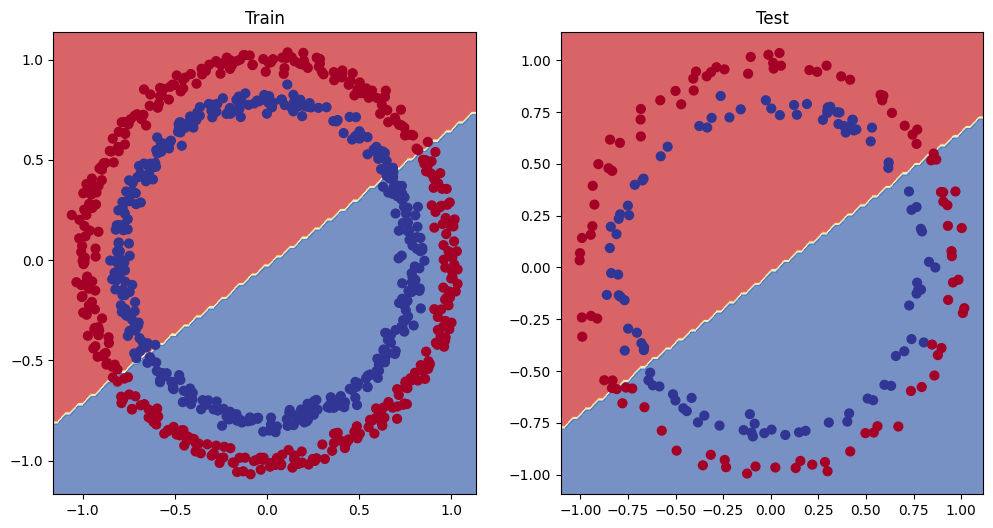

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improving our model

In [33]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # forward pass
  y_logits = model_1.forward(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # loss fn
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # zero
  optimizer.zero_grad()

  # backward
  loss.backward()

  # step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1.forward(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}\nTrain loss: {loss:.5f}\tTrain Acc: {acc:.2f}%\nTest loss: {test_loss:.5f} \tTest Acc: {test_acc:.2f}%\n")

Epoch: 0
Train loss: 0.69396	Train Acc: 50.88%
Test loss: 0.69261 	Test Acc: 51.00%

Epoch: 100
Train loss: 0.69305	Train Acc: 50.38%
Test loss: 0.69379 	Test Acc: 48.00%

Epoch: 200
Train loss: 0.69299	Train Acc: 51.12%
Test loss: 0.69437 	Test Acc: 46.00%

Epoch: 300
Train loss: 0.69298	Train Acc: 51.62%
Test loss: 0.69458 	Test Acc: 45.00%

Epoch: 400
Train loss: 0.69298	Train Acc: 51.12%
Test loss: 0.69465 	Test Acc: 46.00%

Epoch: 500
Train loss: 0.69298	Train Acc: 51.00%
Test loss: 0.69467 	Test Acc: 46.00%

Epoch: 600
Train loss: 0.69298	Train Acc: 51.00%
Test loss: 0.69468 	Test Acc: 46.00%

Epoch: 700
Train loss: 0.69298	Train Acc: 51.00%
Test loss: 0.69468 	Test Acc: 46.00%

Epoch: 800
Train loss: 0.69298	Train Acc: 51.00%
Test loss: 0.69468 	Test Acc: 46.00%

Epoch: 900
Train loss: 0.69298	Train Acc: 51.00%
Test loss: 0.69468 	Test Acc: 46.00%



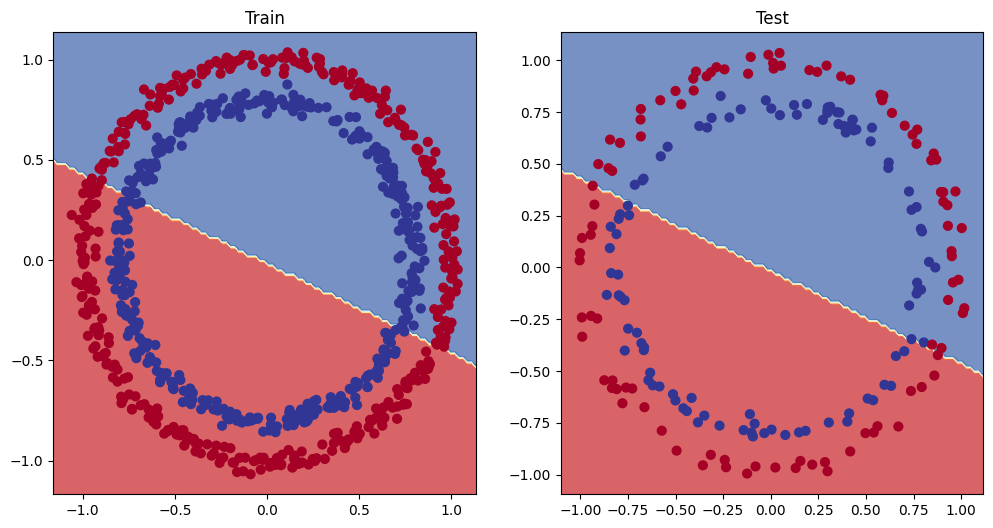

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Linear Regression DS

In [43]:
weight = 0.7
bias = 0.3
start = 0
stop = 1
step = 0.01

X_regression = torch.arange(start, stop, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [44]:
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42)

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

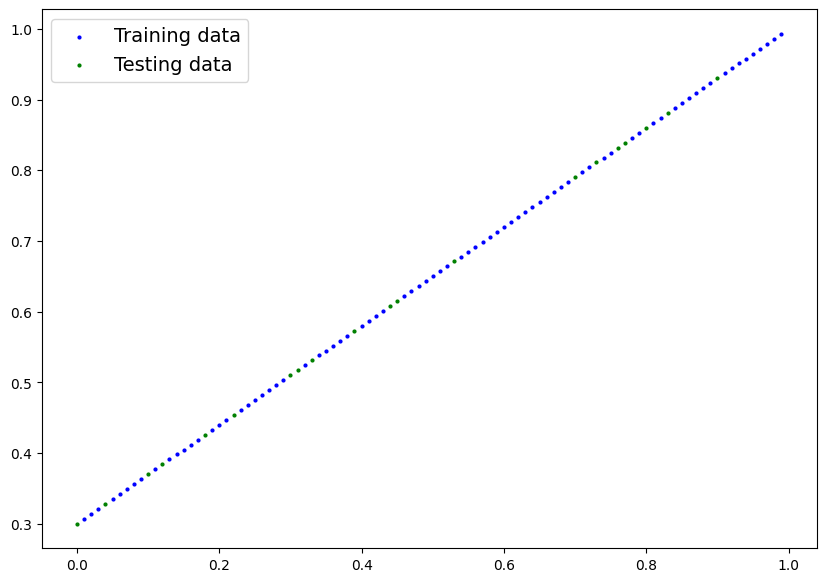

In [46]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

In [47]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 250

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()
  y_preds = model_2.forward(X_train_regression)
  train_loss = loss_fn(y_preds, y_train_regression)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_preds = model_2.forward(X_test_regression)
    test_loss = loss_fn(test_preds, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}")

Epoch: 0	Train loss: 0.06002	Test loss: 0.04944
Epoch: 100	Train loss: 0.06560	Test loss: 0.04143
Epoch: 200	Train loss: 0.05967	Test loss: 0.04788


In [61]:
model_2.eval()
with torch.inference_mode():
  preds = model_2.forward(X_test_regression)

preds[:5]

tensor([[0.8949],
        [0.7071],
        [0.8135],
        [0.6569],
        [0.6507]])

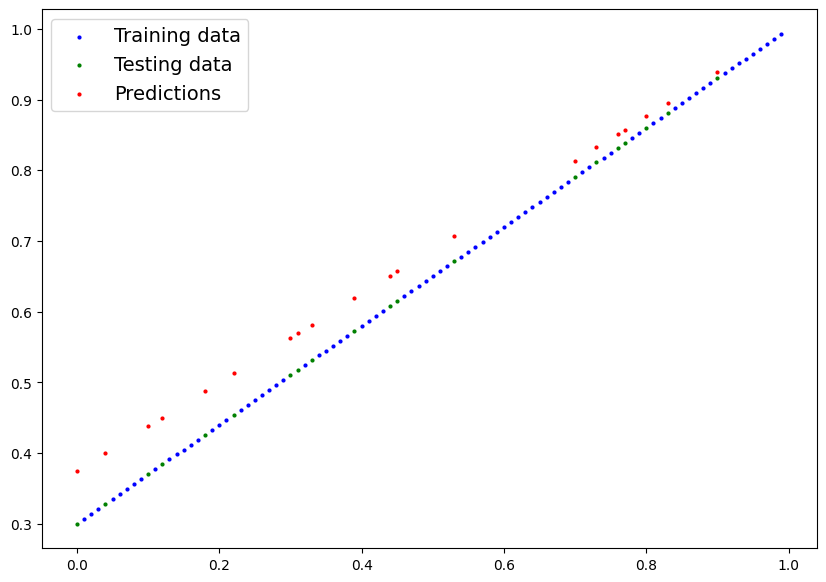

In [62]:
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=preds.cpu());

### Non-linear models

In [78]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()

model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [79]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [83]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.01)

In [84]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3.forward(X_train).squeeze()
  train_preds = torch.round(torch.sigmoid(y_logits))
  train_loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_train, train_preds)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3.forward(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}\nTrain Loss: {train_loss:.4f}\tTrain Accuracy: {train_acc:.2f}%\nTest Loss: {test_loss:.4f} \tTest Accuracy: {test_acc:.2f}%\n")

Epoch: 0
Train Loss: 0.5682	Train Accuracy: 87.75%
Test Loss: 0.5743 	Test Accuracy: 86.50%

Epoch: 100
Train Loss: 0.5608	Train Accuracy: 88.50%
Test Loss: 0.5680 	Test Accuracy: 88.00%

Epoch: 200
Train Loss: 0.5531	Train Accuracy: 89.25%
Test Loss: 0.5614 	Test Accuracy: 89.00%

Epoch: 300
Train Loss: 0.5452	Train Accuracy: 90.00%
Test Loss: 0.5546 	Test Accuracy: 89.50%

Epoch: 400
Train Loss: 0.5369	Train Accuracy: 90.75%
Test Loss: 0.5475 	Test Accuracy: 89.50%

Epoch: 500
Train Loss: 0.5284	Train Accuracy: 91.38%
Test Loss: 0.5401 	Test Accuracy: 89.50%

Epoch: 600
Train Loss: 0.5197	Train Accuracy: 92.38%
Test Loss: 0.5326 	Test Accuracy: 89.50%

Epoch: 700
Train Loss: 0.5105	Train Accuracy: 92.75%
Test Loss: 0.5248 	Test Accuracy: 90.00%

Epoch: 800
Train Loss: 0.5011	Train Accuracy: 93.12%
Test Loss: 0.5166 	Test Accuracy: 90.00%

Epoch: 900
Train Loss: 0.4914	Train Accuracy: 93.50%
Test Loss: 0.5083 	Test Accuracy: 89.50%



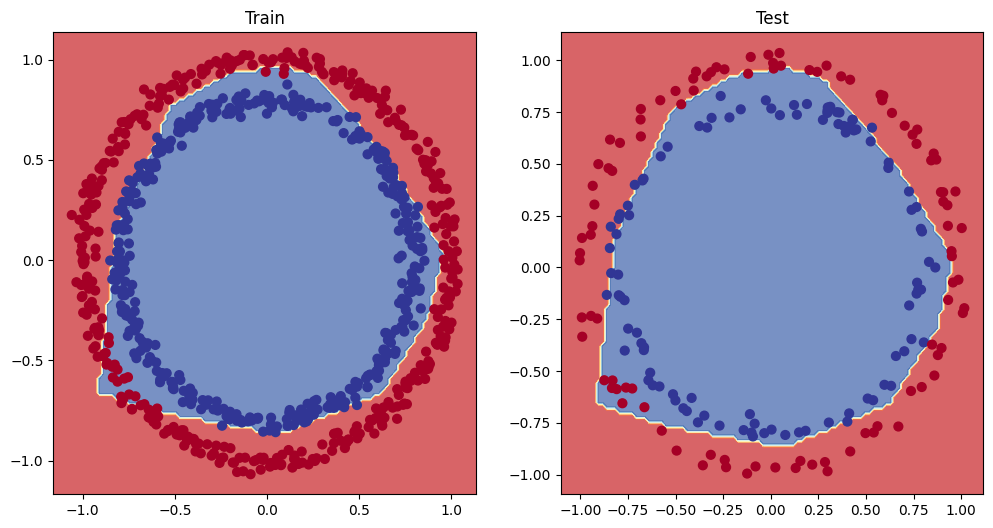

In [85]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)